In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json # to read credentials

# SQL stuff
#import psycopg2 as ps
#import pandas.io.sql as sqlio
#from sqlalchemy import create_engine
#from sqlalchemy.types import Integer, Text, String, DateTime
#engine = create_engine('sqlite://', echo=False)
#from pyspark.sql.functions import size,col

# TRINO stuff
import trino

# Regex stuff
import re

# PDF stuff
import PyPDF2 as pypdf

# Dates stuff
from datetime import datetime, date, timedelta

# GSheet Stuff
from gspread_pandas import Spread

# Computer Stuff
import os

# Dates stuff
from datetime import datetime, date, timedelta

import pathlib
from mizani.breaks import date_breaks

# Operating system stuff
#import pathlib 

# Plot stuff
import plotnine as pn

# Statistics stuff + DS stuff
from sklearn.metrics import roc_curve, precision_recall_curve

# Statistics Stuff
from statsmodels.stats.proportion import proportion_confint, test_proportions_2indep, proportion_effectsize

In [2]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

# To manually explore rows
#with trino.dbapi.connect(**conn_details) as conn:
#    cur = conn.cursor()
#    cur.execute(pv_success_q)
#    rows = cur.fetchall()

In [3]:
cash_unpaid_query = """ 
SELECT DISTINCT
    DATE (date_trunc('day'
   , rfs.risk_feature_snapshot_creation_datetime)) AS creation_date
   , CASE WHEN NULLIF (json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'), ' ') IS NOT NULL THEN 'shadowing' ELSE 'production' END AS is_shadowing
        , CASE WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 0 THEN 'NC' ELSE 'EC'
END AS customer_type
        , CASE WHEN p.payment_status = 'NOT_PAID' THEN 1 ELSE 0
END AS unpaid
        , o.order_total_purchase_eur AS gmv_euros
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') AS shadowing_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') AS production_score
        , json_extract_scalar(rfs.features, '$.customer.country') AS order_country
        , rd.decision_id AS decision_id

FROM  sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced rfs 
            INNER JOIN (SELECT customer_id FROM legacy_dwh.public.risk_user_hashing WHERE CAST(hash_crc32 AS real) < (0.04 * CAST(4294967295 AS real)) ) AS cg 
                                                                                        ON cg.customer_id = rfs.customer_id
            LEFT JOIN sensitive_delta.central_risk_engine_odp.risk_decisions rd         ON rd.decision_id=rfs.decision_id
            LEFT JOIN sensitive_delta.central_checkout_orders_odp.checkout_orders co    ON co.checkout_id = rfs.checkout_id
            LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 o        ON o.order_id = co.order_id
            LEFT JOIN delta.fintech_payments_odp.payments p                             ON p.order_id = o.order_id
WHERE rfs.checkpoint = 'checkout'
      AND p.payment_method = 'CASH'
      AND p.bundled_payment_parent_id IS NULL 
      AND rfs.p_creation_date >= date('2023-11-21')
      AND o.order_final_status IN ('CanceledStatus', 'DeliveredStatus')
      AND NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') IS NOT NULL AND NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') IS NOT NULL
"""
    

In [4]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(cash_unpaid_query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/4090419599.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [5]:
df

,creation_date,is_shadowing,customer_type,unpaid,gmv_euros,shadowing_score,production_score,order_country,decision_id
0,2023-12-10,shadowing,EC,0,8.942314,0,0,PL,602eae33-ba5d-4281-be91-3579c7ed19ef
1,2023-11-30,shadowing,EC,0,13.878294,0,0,MA,57266349-8419-4c7d-80f4-5f96c7bd182c
2,2023-12-04,shadowing,EC,0,10.575372,0,0,MA,8319917d-8fec-4093-a9f4-6d2bb3cebe94
3,2023-12-05,shadowing,EC,0,0.000000,0,0,PL,243dffc2-edbb-49ab-bbe7-a3f04e80410f
4,2023-12-02,shadowing,EC,0,6.055050,0,0,RO,20d224df-477c-4153-8adb-5654ed09c452
...,...,...,...,...,...,...,...,...,...
150436,2023-12-09,shadowing,EC,0,21.100000,0,0,PT,a27b42c2-6adc-4752-be60-96fe821663c9
150437,2023-12-01,shadowing,EC,0,25.000000,0,0,IT,a72bd95a-c747-4b1b-93ea-95568c2de6de
150438,2023-12-05,shadowing,NC,0,6.159688,0,0,RO,1d6d4670-79c8-4ff3-a381-08c088437d24
150439,2023-11-24,shadowing,NC,0,19.500000,22,30,IT,3cf507b8-d546-4bb5-98a8-3cdb817b8124


In [6]:
len(df['is_shadowing'])

150441

# Function definitions

In [7]:
def plot_roc_curve(df, preds_col=None):

    if preds_col == None:
        preds_col = "captcha_score"

    # Create the ROC curve
    fpr, tpr, thresholds = roc_curve(df['is_legit'], df[preds_col])

    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

# Create the data viz
    print(f"Thresholds: {thresholds}")
    return (
        pn.ggplot(data = df_fpr_tpr)+
        pn.geom_point(
            pn.aes(
                x = 'FPR',
                y = 'TPR',
                size='Threshold',
                color='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x = 'FPR',
                y = 'TPR'
            )
        ) +
        pn.labs(title = 'ROC Curve')+
        pn.xlab('False Positive Rate')+
        pn.ylab('True Positive Rate')+
        pn.theme_minimal()
    )

In [8]:
def plot_precision_recall(df, preds_col=None):

    if preds_col == None:
        preds_col = "captcha_score"

    # Create the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(df['is_legit'], df[preds_col])

    # Plot the ROC curve
    df_recall_precision = pd.DataFrame({
        'Precision':precision[:-1],
        'Recall':recall[:-1],
        'Threshold':thresholds
    })

# Creat a data viz
    return(
        pn.ggplot(data = df_recall_precision) +
        pn.geom_point(
            pn.aes(
                x = 'Recall',
                y = 'Precision',
                size='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x = 'Recall',
                y = 'Precision'
            )
        )+
        pn.labs(title = 'Recall Precision Curve')+
        pn.xlab('Recall')+
        pn.ylab('Precision')+
        pn.theme_minimal()
    )

# Invocations

In [9]:
df.isna().sum()

creation_date         0
is_shadowing          0
customer_type         0
unpaid                0
gmv_euros             0
shadowing_score       0
production_score      0
order_country       250
decision_id           0
dtype: int64

In [10]:
#df['production_score'] = df['production_score'].replace('', np.nan).astype(float)
#df['shadowing_score'] = df['shadowing_score'].replace('', np.nan).astype(float)

In [11]:
df.dtypes

creation_date        object
is_shadowing         object
customer_type        object
unpaid                int64
gmv_euros           float64
shadowing_score      object
production_score     object
order_country        object
decision_id          object
dtype: object

In [12]:
df['unpaid']=df['unpaid'].astype('object')
df['creation_date']=pd.to_datetime(df['creation_date'])

# Production score

In [13]:
production_score = df[df['production_score'].notna()][['creation_date', 'unpaid']].groupby(
    ['unpaid', pd.Grouper(key='creation_date', freq='1D')]
    ).agg(
        counts = ('creation_date', 'count')
    ).reset_index()

In [14]:
production_score['unpaid'] = production_score['unpaid'].astype('category')

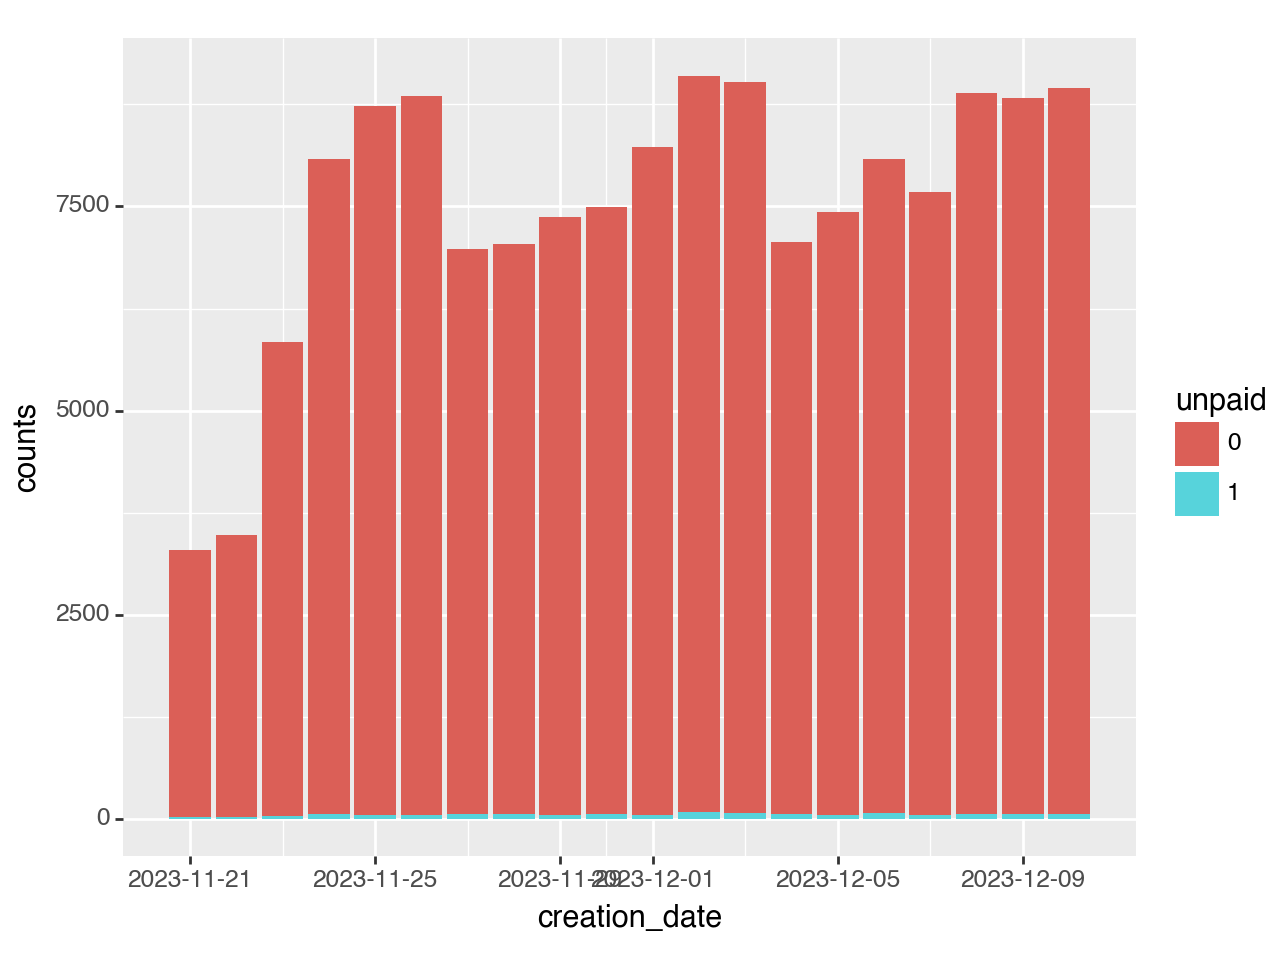

<Figure Size: (640 x 480)>

In [15]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(production_score.reset_index(), pn.aes(x='creation_date', y='counts', fill='unpaid')) +
    pn.geom_col()#+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Shadowing score

In [16]:
shadowing_score = df[df['shadowing_score'].notna()][['creation_date', 'unpaid']].groupby(
    ['unpaid', pd.Grouper(key='creation_date', freq='1D')]
    ).agg(
        counts = ('creation_date', 'count')
    ).reset_index()

In [17]:
shadowing_score['unpaid'] = shadowing_score['unpaid'].astype('category')

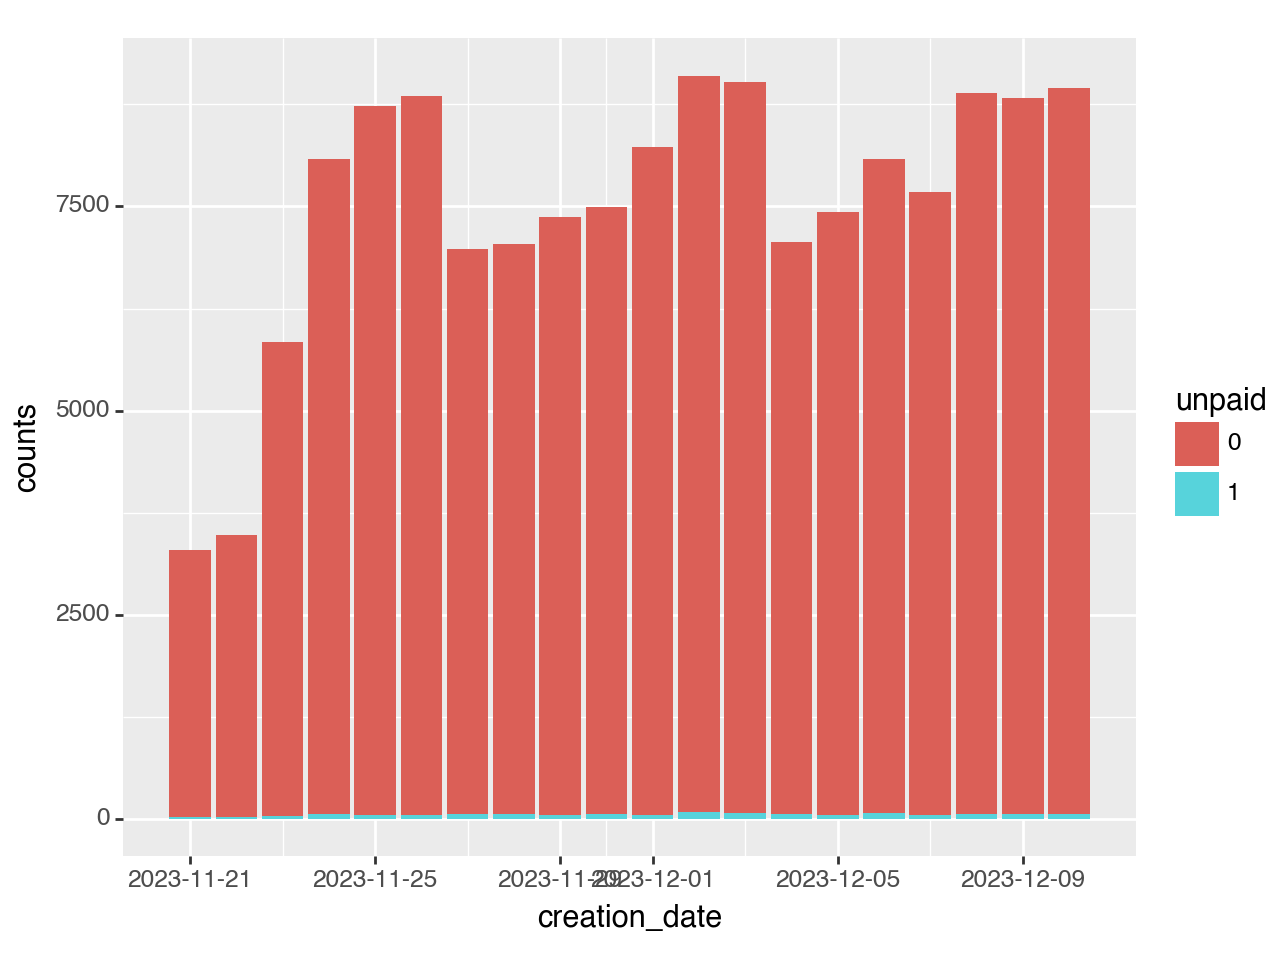

<Figure Size: (640 x 480)>

In [18]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(shadowing_score.reset_index(), pn.aes(x='creation_date', y='counts', fill='unpaid')) +
    pn.geom_col()#+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Crosstab

In [19]:
# Ground truth, the user has a successful verification and at least 1 order is a trusted user, in case not a bot.
pd.crosstab(
    df['customer_type'],
    df['unpaid'],
    dropna=False,
    normalize='all'
)

unpaid,0,1
customer_type,,
EC,0.917908,0.005796
NC,0.074321,0.001974


# Subsetting data

In [20]:
df_out = df[["production_score", "shadowing_score","unpaid", "customer_type"]]

In [21]:
#df['production_score_quantiles']=df['production_score'].quantile(np.arange(0, 1.1, 0.1))

In [22]:
df_out['unpaid'] = df_out['unpaid'].astype(int)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/4235601230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Production Score

In [23]:
df_production_score=pd.DataFrame(df_out['production_score'].value_counts()/len(df_out))
df_production_score = df_production_score.reset_index()
df_production_score.columns=['production_score','percentage']
df_production_score

,production_score,percentage
0,0,0.824822
1,1,0.022753
2,2,0.014378
3,3,0.011187
4,4,0.008861
...,...,...
95,75,0.000259
96,74,0.000246
97,85,0.000219
98,77,0.000219


# Shadowing Score

In [24]:
df_shadowing_score=pd.DataFrame(df_out['shadowing_score'].value_counts()/len(df_out))
df_shadowing_score = df_shadowing_score.reset_index()
df_shadowing_score.columns=['shadowing_score','percentage']
df_shadowing_score

,shadowing_score,percentage
0,0,0.899775
1,1,0.021018
2,2,0.013128
3,3,0.007332
4,4,0.007013
...,...,...
95,72,0.000060
96,68,0.000053
97,69,0.000047
98,73,0.000040


In [25]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [26]:
display_side_by_side(df_production_score,df_shadowing_score, titles=['Production Score','Shadowing Score'])

,production_score,percentage
0,0,0.824822
1,1,0.022753
2,2,0.014378
3,3,0.011187
4,4,0.008861
5,5,0.007219
6,6,0.006461
7,7,0.005889
8,8,0.005078
9,9,0.004553


In [27]:
df_out['production_score'] = df_out['production_score'].astype(int)
df_out['shadowing_score'] = df_out['shadowing_score'].astype(int)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/3955401180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/3955401180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
sorted_data = df_out.sort_values(by='production_score', ascending=True).copy()
bins = sorted_data['production_score'].unique()

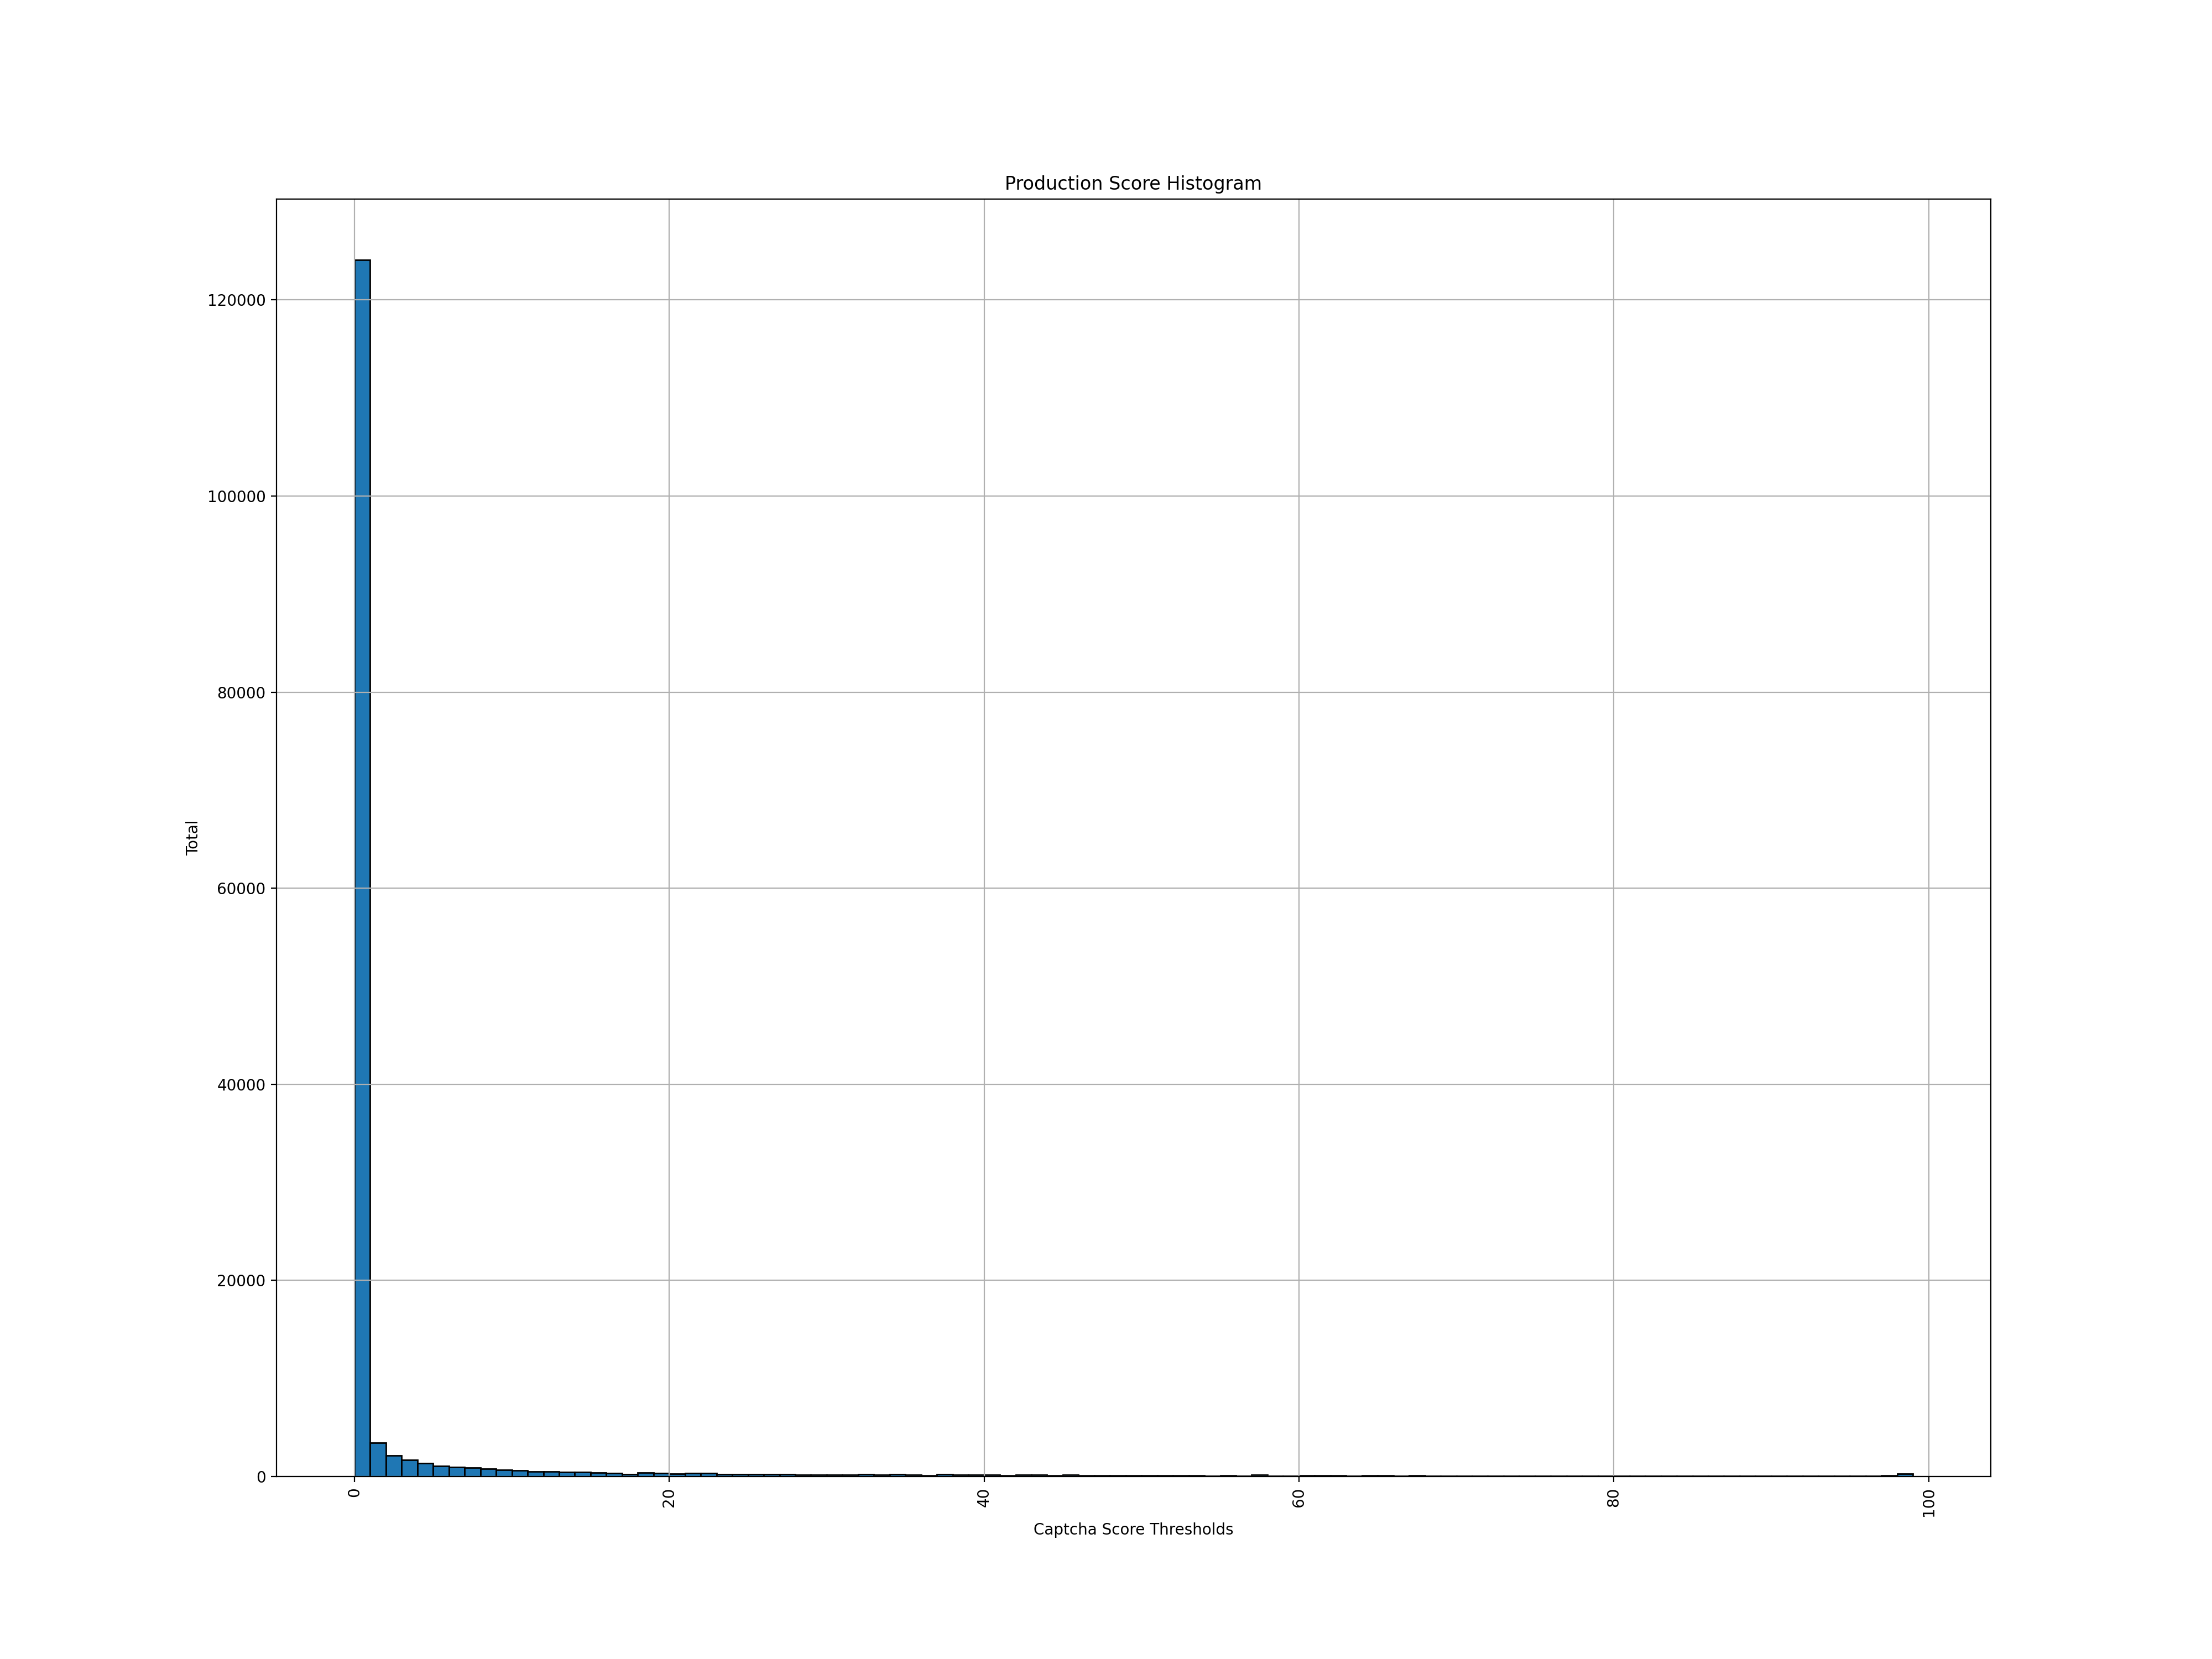

In [29]:
plt.figure(figsize=(20, 15)) 
sorted_data['production_score'].hist(bins=bins, edgecolor='black')
plt.title("Production Score Histogram")
plt.ylabel("Total")
plt.xlabel("Captcha Score Thresholds")
plt.xticks(rotation='vertical') 
plt.show()

In [30]:
sorted_data = df_out.sort_values(by='shadowing_score', ascending=True).copy()
bins = sorted_data['shadowing_score'].unique()

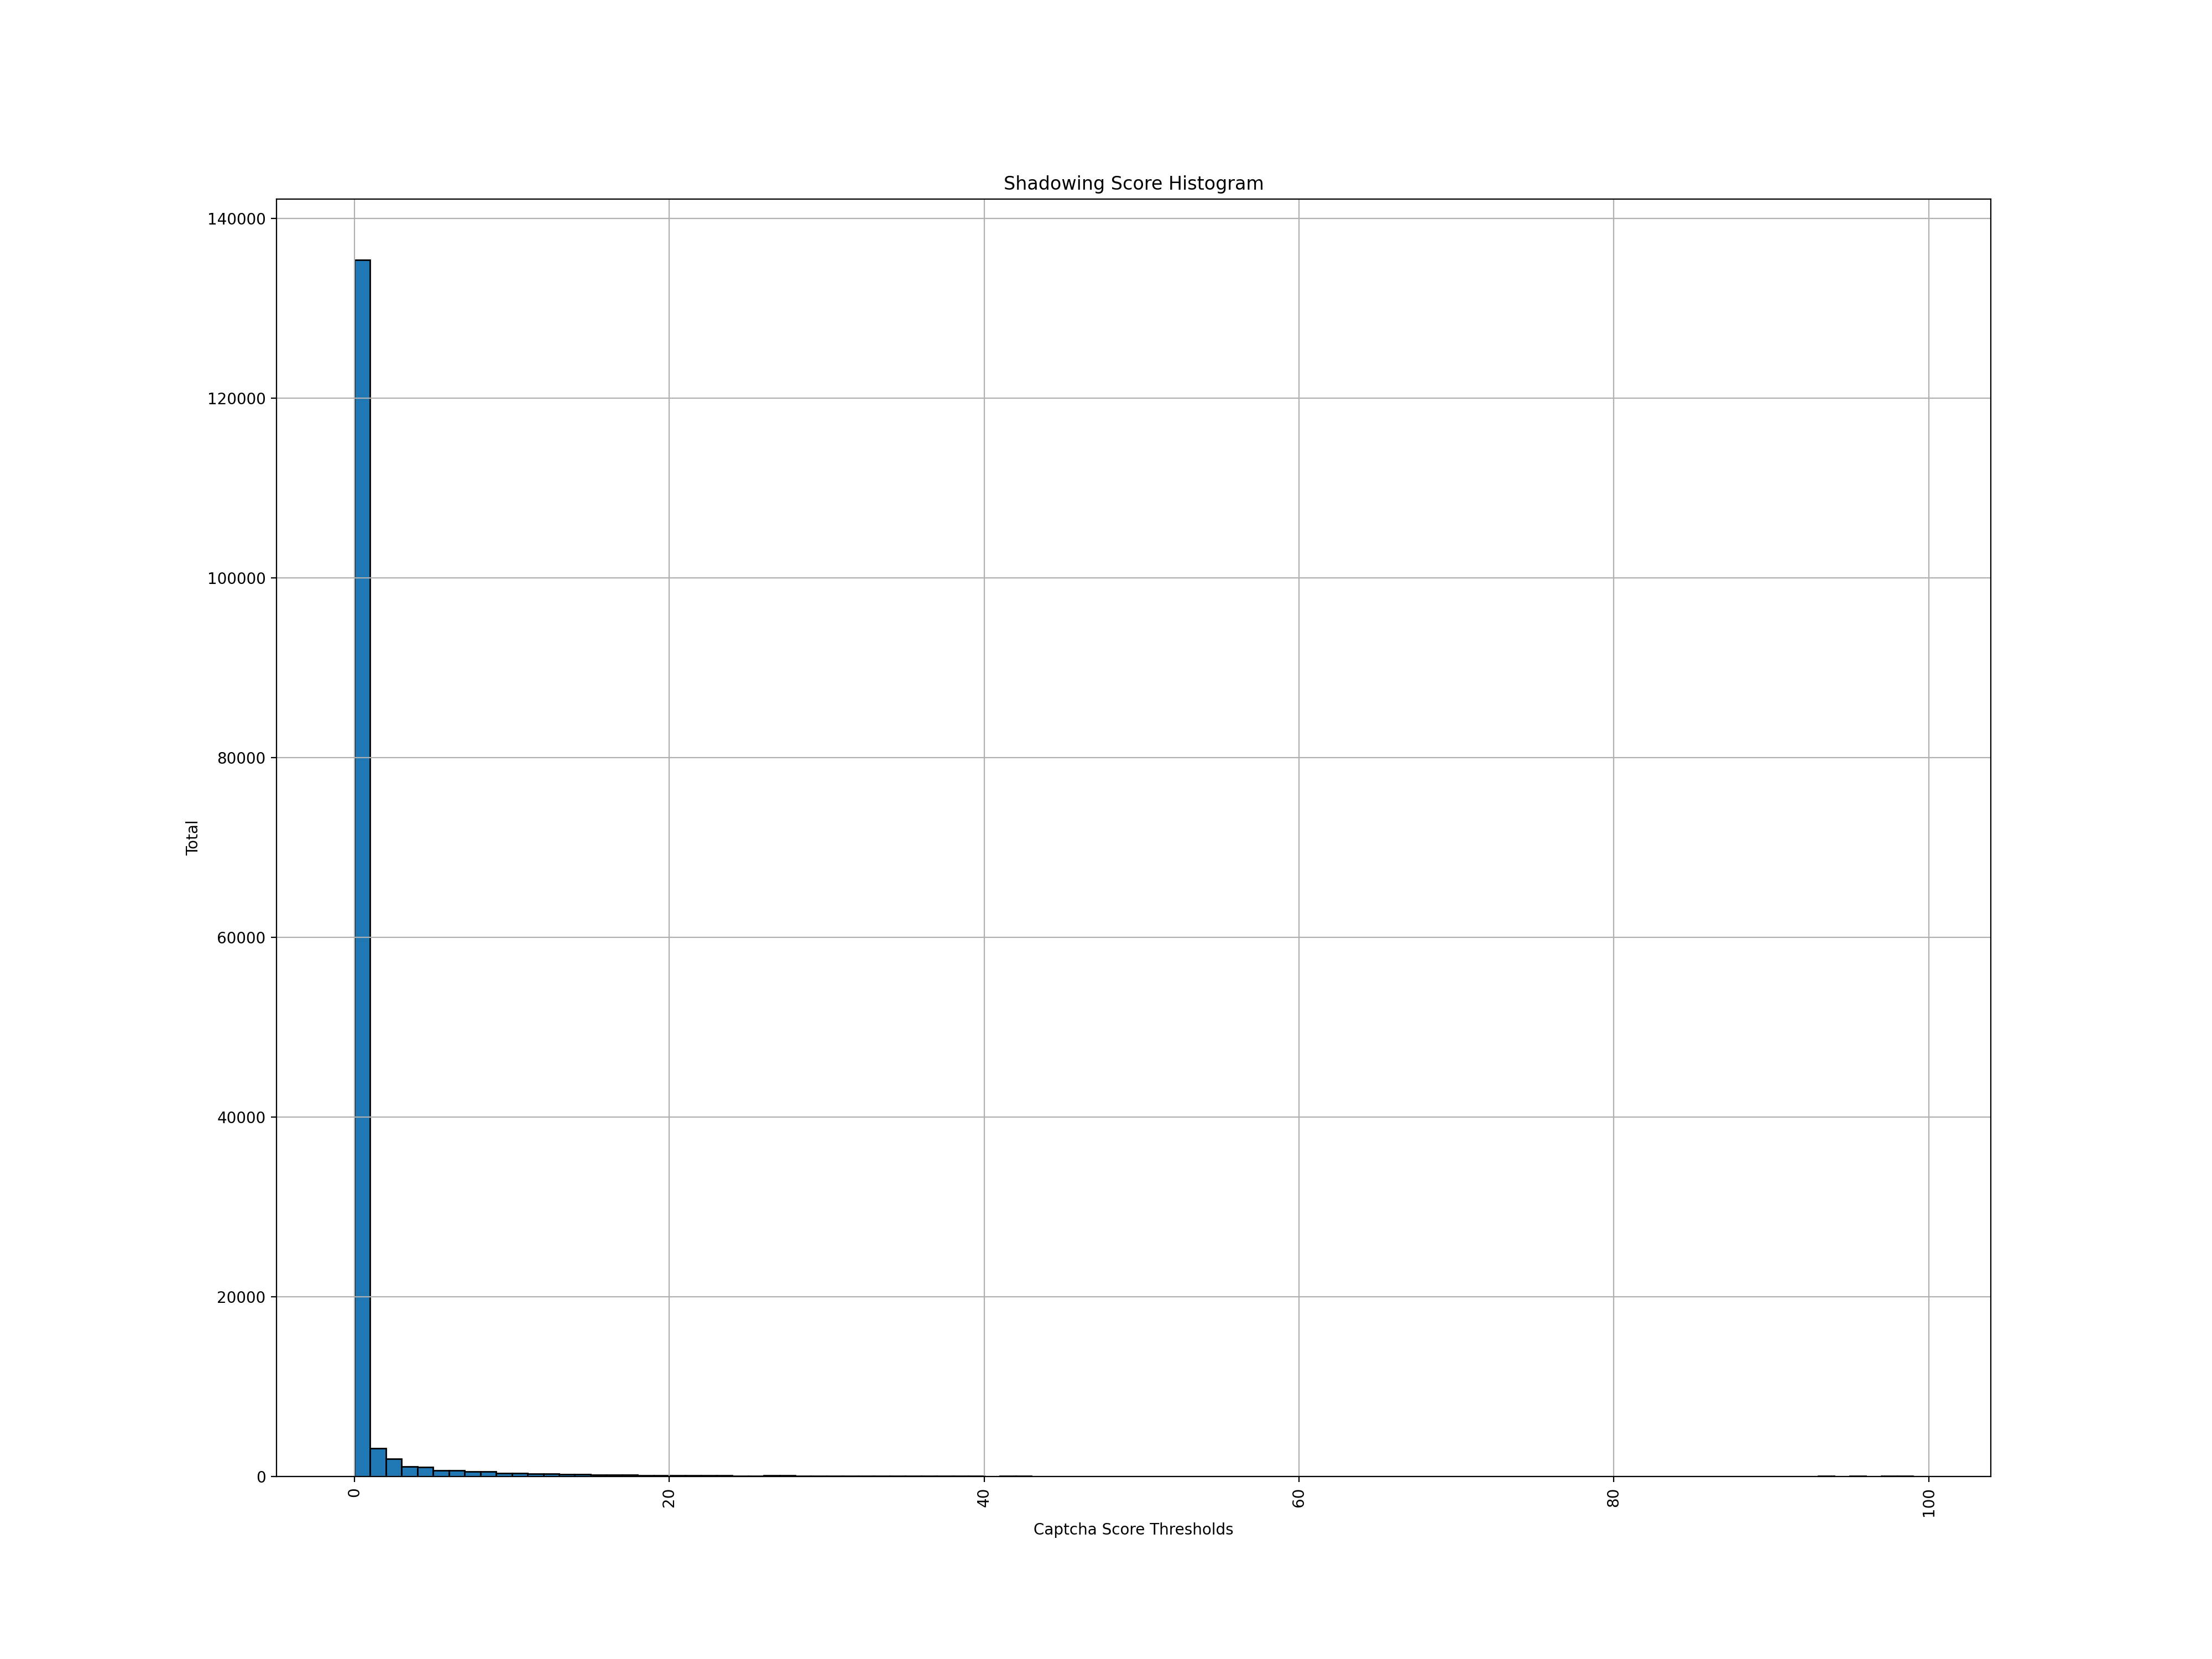

In [31]:
plt.figure(figsize=(20, 15)) 
sorted_data['shadowing_score'].hist(bins=bins, edgecolor='black')
plt.title("Shadowing Score Histogram")
plt.ylabel("Total")
plt.xlabel("Captcha Score Thresholds")
plt.xticks(rotation='vertical') 
plt.show()

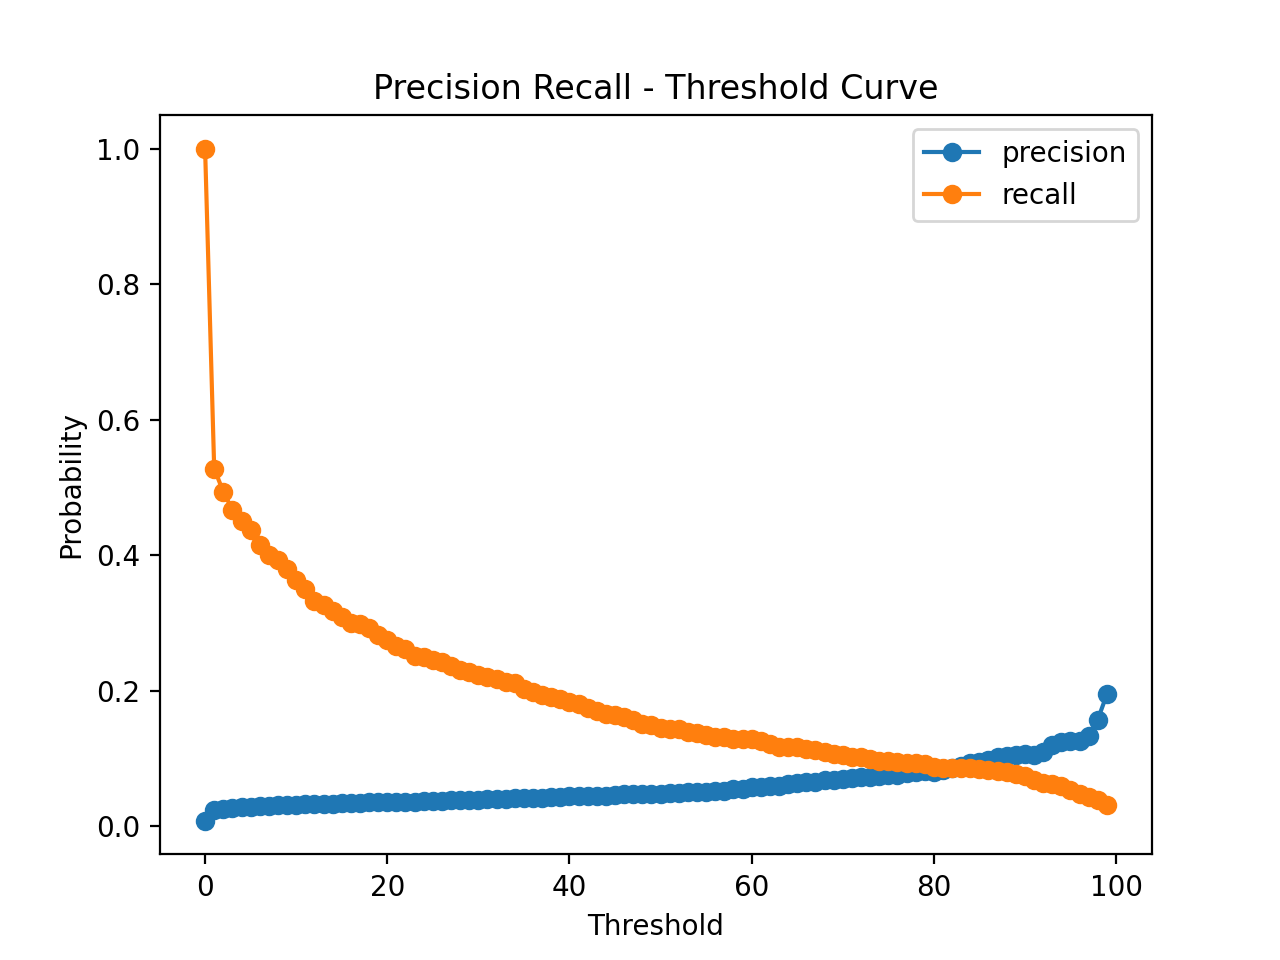

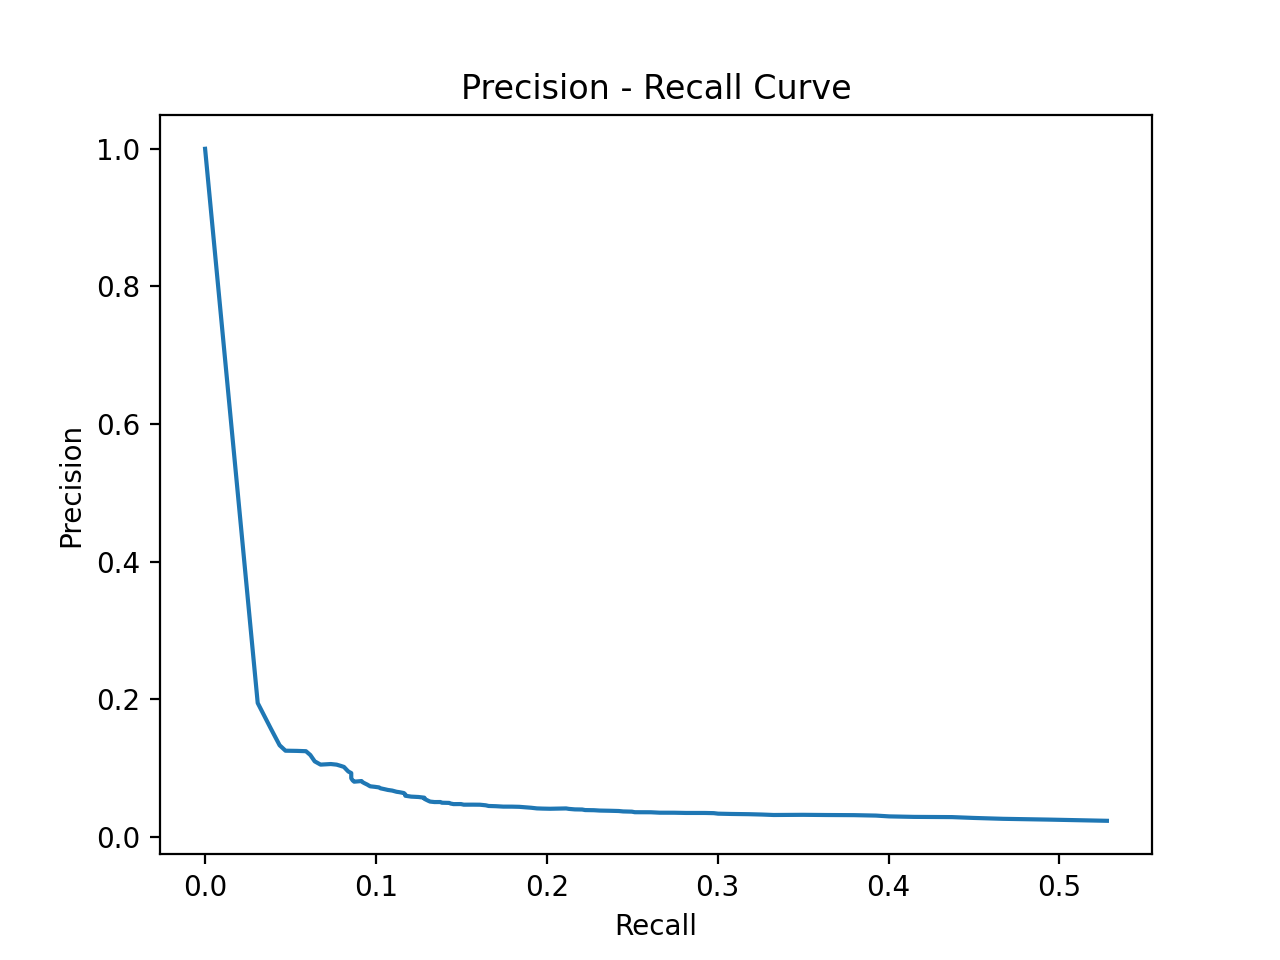

In [32]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is production model for detecting unpaid cash being 1 the positive label.
prec_1, recall_1, thresholds_1 = precision_recall_curve(df_out['unpaid'].values, df_out['production_score'].values, pos_label=1)

plt.plot(thresholds_1[:], prec_1[:-1], label='precision', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve")
plt.ylabel("Probability")
plt.xlabel("Threshold")



plt.figure()

plt.plot(recall_1[1:], prec_1[1:])
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

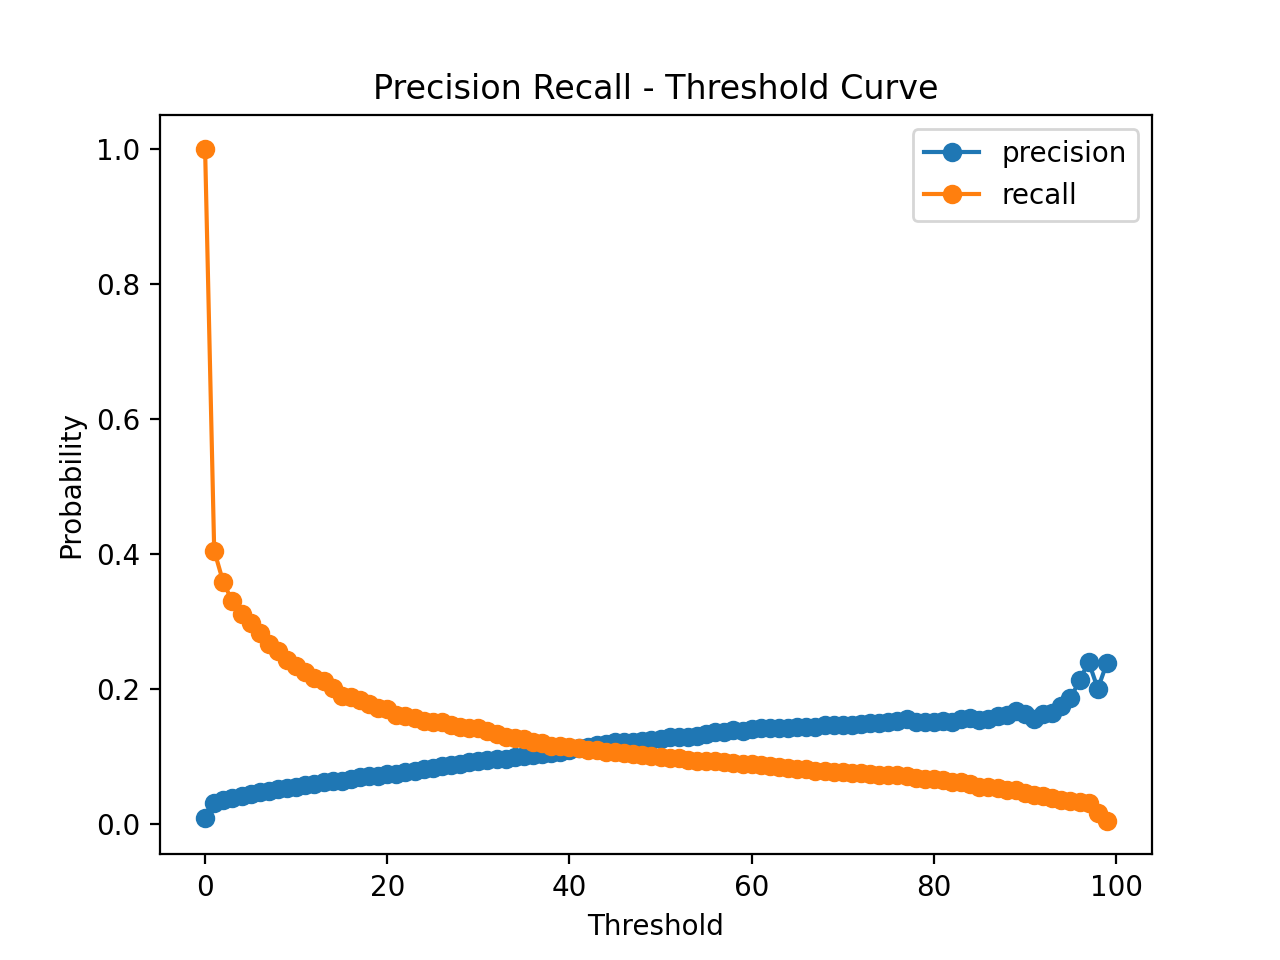

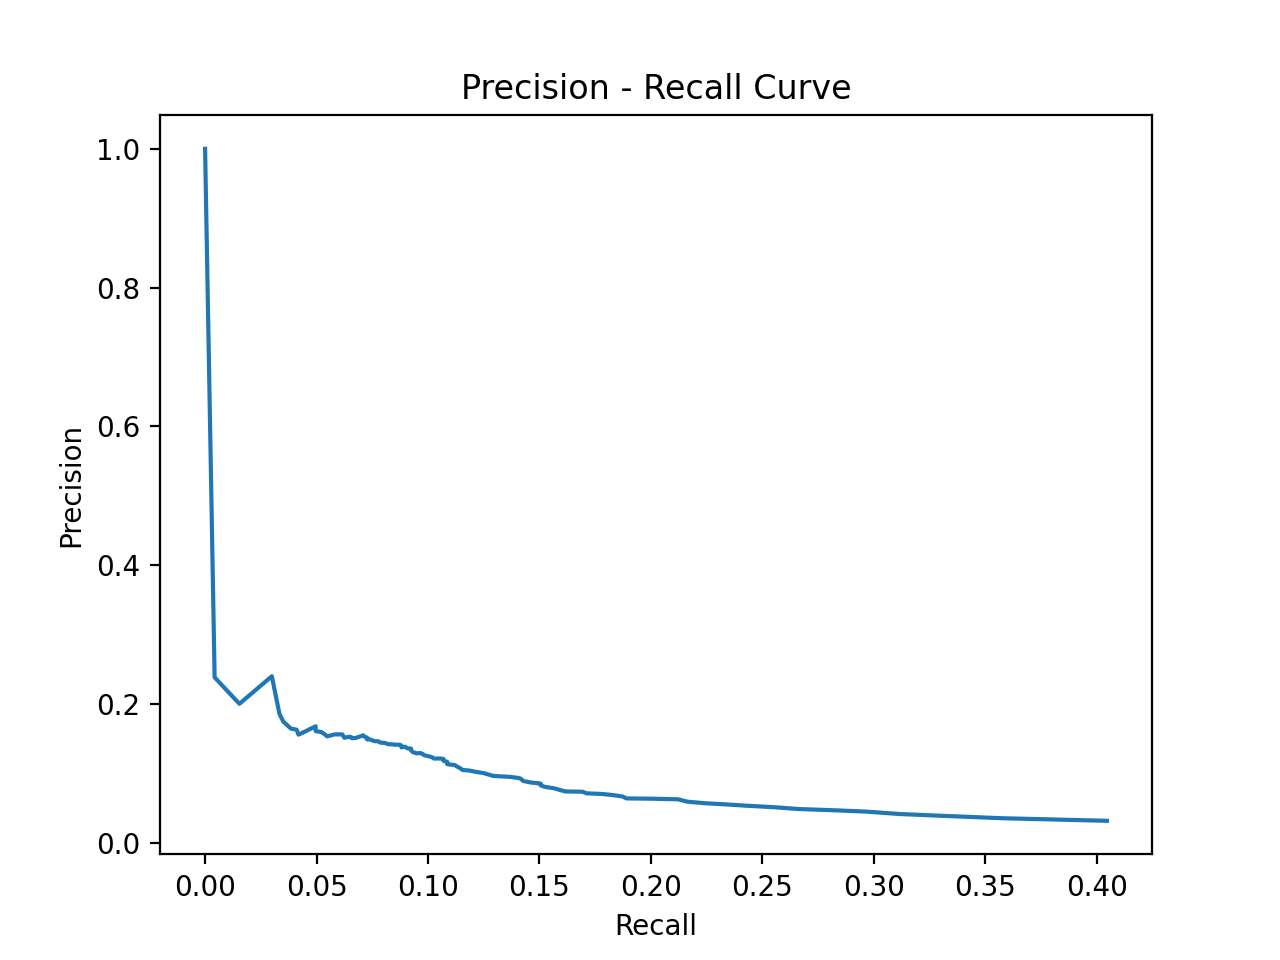

In [33]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is shadowing model for detecting unpaid cash being 1 the positive label.
prec_2, recall_2, thresholds_2 = precision_recall_curve(df_out['unpaid'].values, df_out['shadowing_score'].values, pos_label=1)

plt.plot(thresholds_2[:], prec_2[:-1], label='precision', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve")
plt.ylabel("Probability")
plt.xlabel("Threshold")



plt.figure()

plt.plot(recall_2[1:], prec_2[1:])
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [34]:
df_out  

,production_score,shadowing_score,unpaid,customer_type
0,0,0,0,EC
1,0,0,0,EC
2,0,0,0,EC
3,0,0,0,EC
4,0,0,0,EC
...,...,...,...,...
150436,0,0,0,EC
150437,0,0,0,EC
150438,0,0,0,NC
150439,30,22,0,NC


In [35]:
# Convert payment_status to binary where NOT_PAID is 1 and PAID is 0
df_out['true_label'] = df_out['unpaid']

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/441363051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


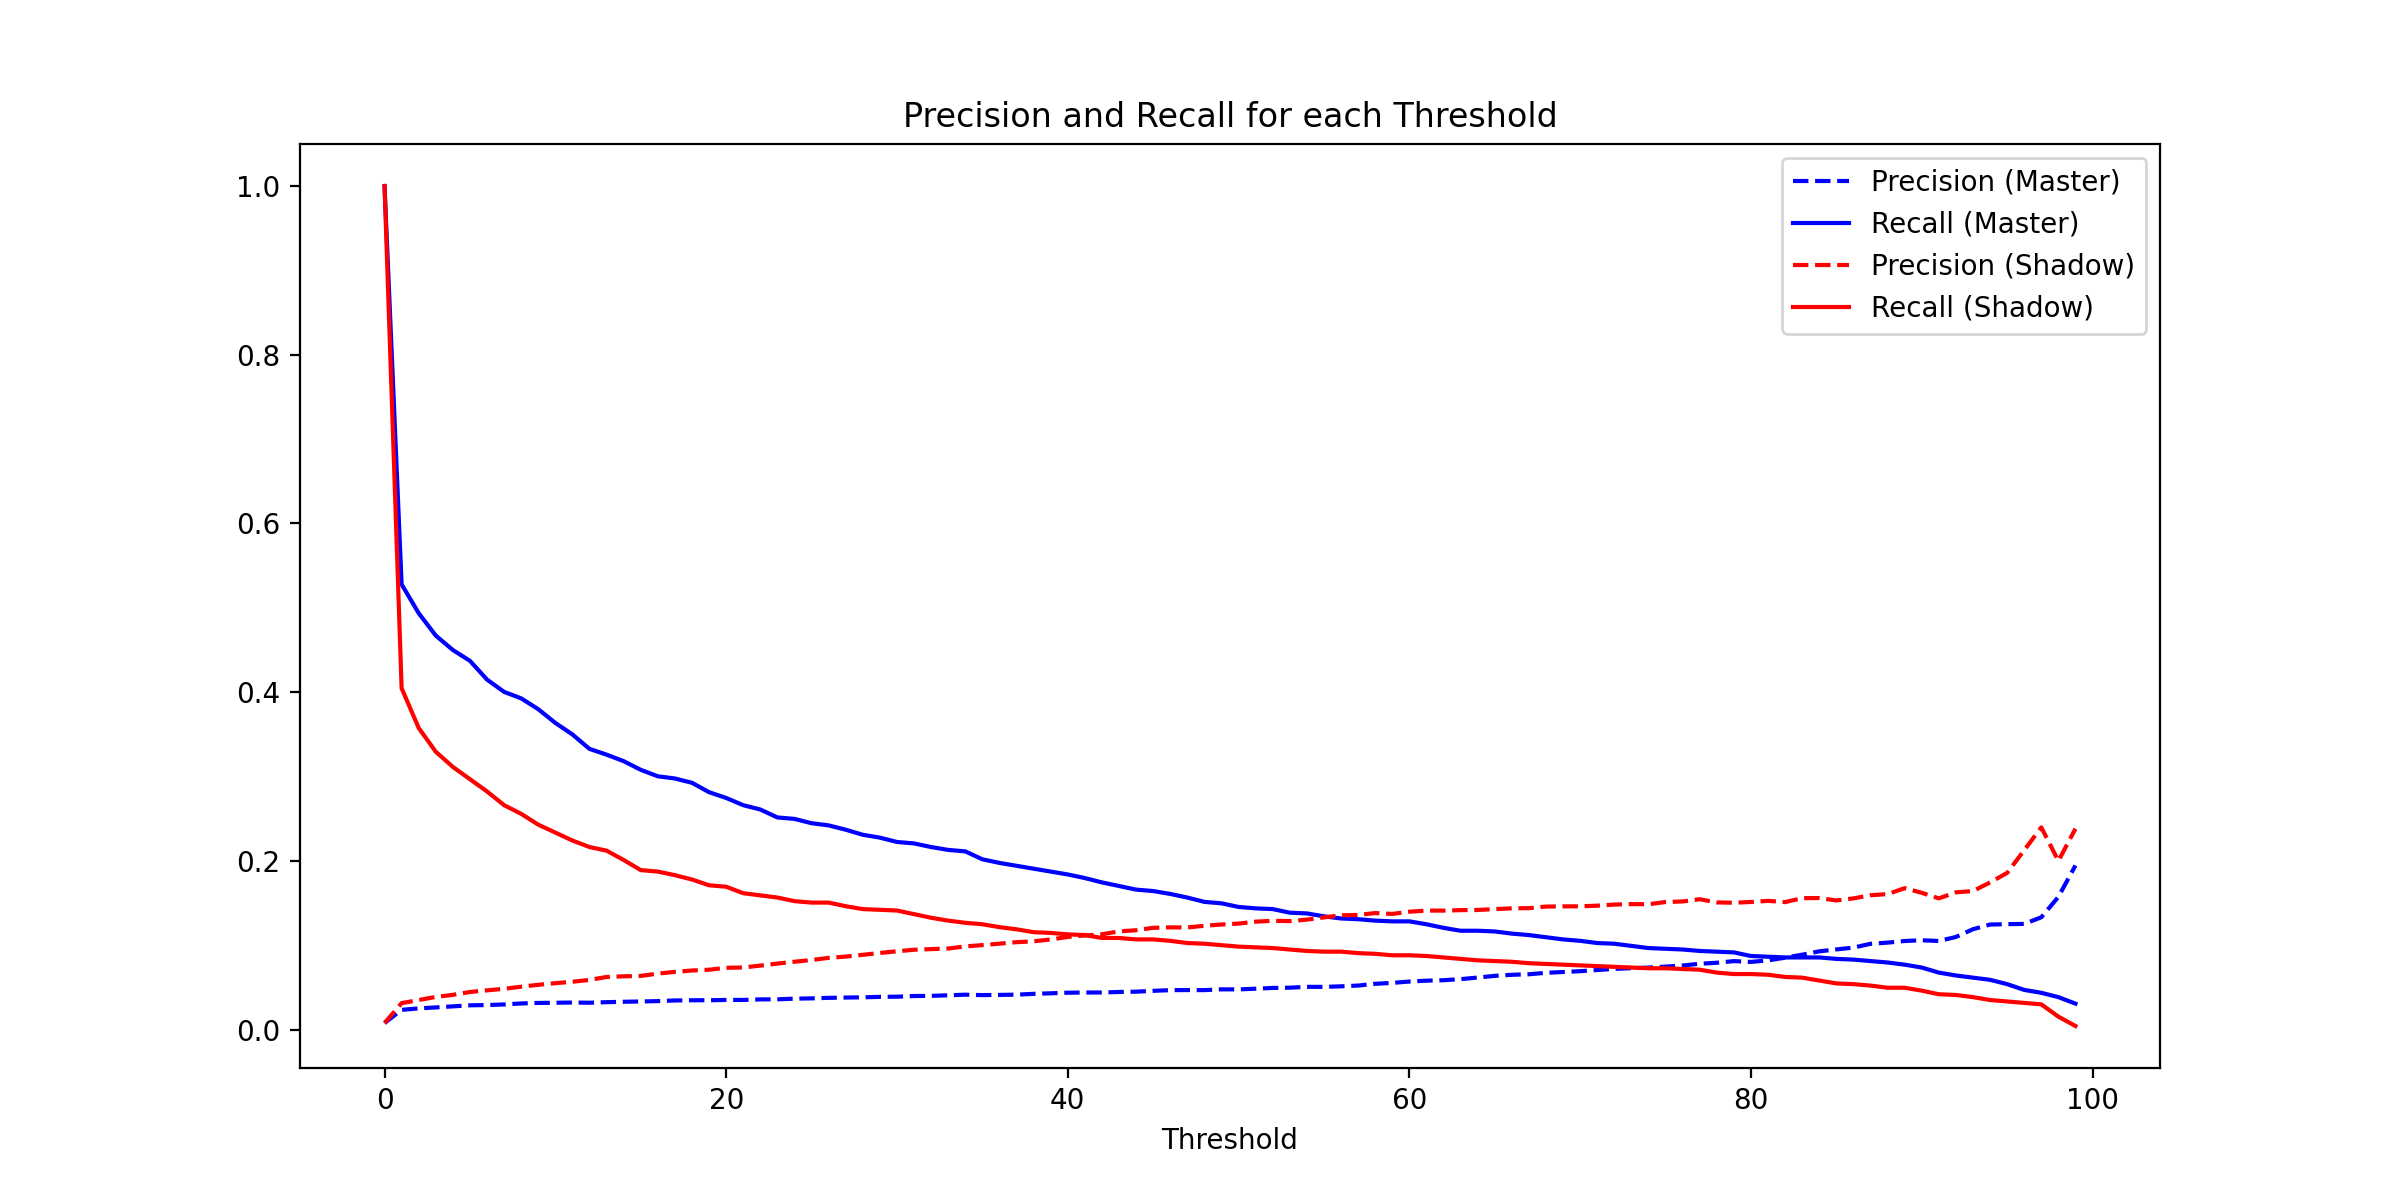

In [36]:
# Calculate precision, recall, and thresholds for each model
precision_master, recall_master, thresholds_master = precision_recall_curve(df_out['true_label'], df_out['production_score'])
precision_shadow, recall_shadow, thresholds_shadow = precision_recall_curve(df_out['true_label'], df_out['shadowing_score'])

# Plot precision and recall against the threshold for each model
plt.figure(figsize=(12, 6))

plt.plot(thresholds_master, precision_master[:-1], 'b--', label='Precision (Master)')
plt.plot(thresholds_master, recall_master[:-1], 'b-', label='Recall (Master)')
plt.plot(thresholds_shadow, precision_shadow[:-1], 'r--', label='Precision (Shadow)')
plt.plot(thresholds_shadow, recall_shadow[:-1], 'r-', label='Recall (Shadow)')
plt.xlabel('Threshold')
plt.title('Precision and Recall for each Threshold')
plt.legend()

plt.show()

In [37]:
df_out

,production_score,shadowing_score,unpaid,customer_type,true_label
0,0,0,0,EC,0
1,0,0,0,EC,0
2,0,0,0,EC,0
3,0,0,0,EC,0
4,0,0,0,EC,0
...,...,...,...,...,...
150436,0,0,0,EC,0
150437,0,0,0,EC,0
150438,0,0,0,NC,0
150439,30,22,0,NC,0


In [38]:
#df_out['','unpaid'].value_counts()

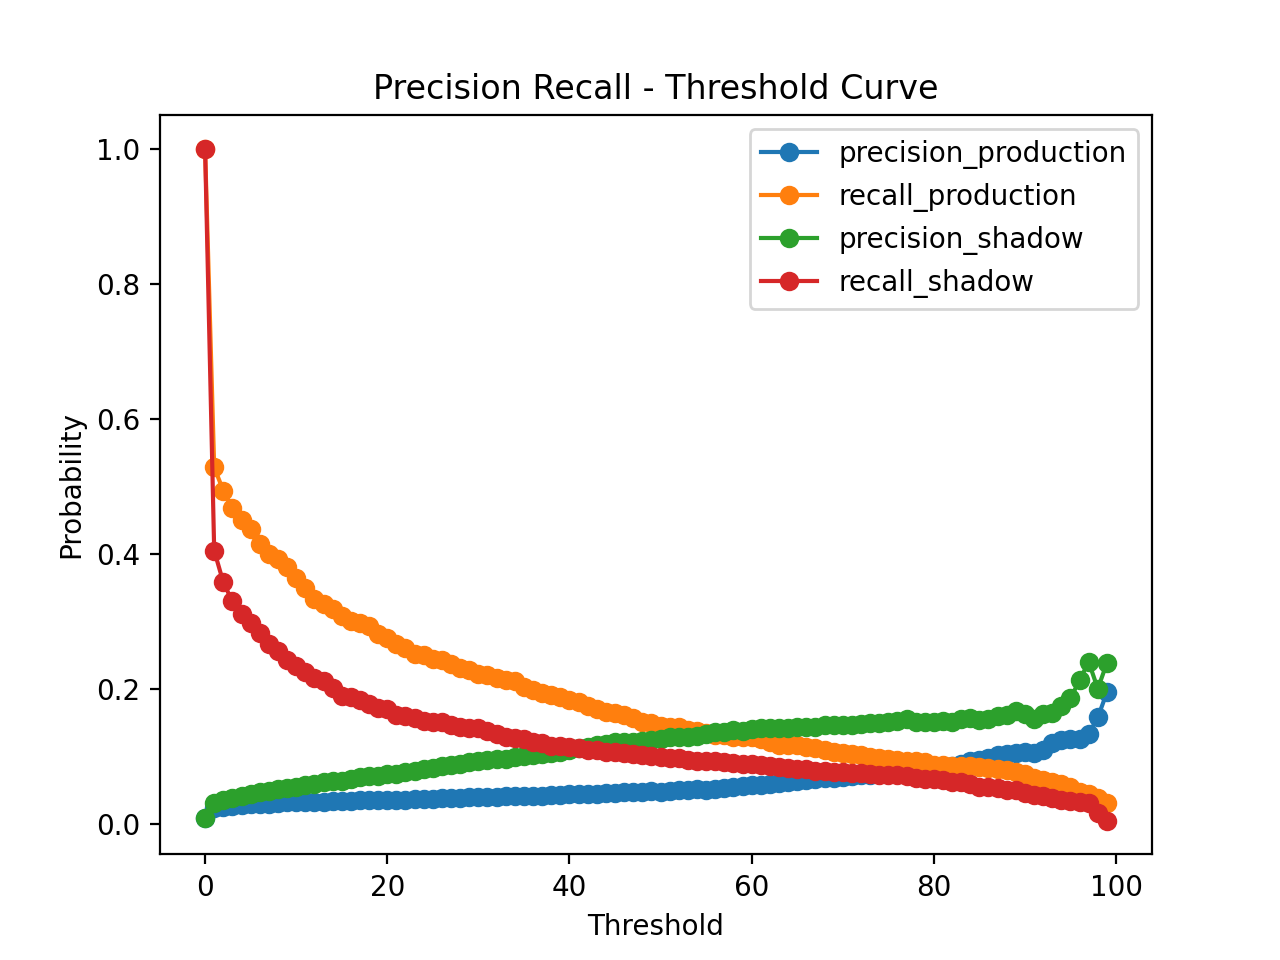

In [39]:
plt.plot(thresholds_1[:], prec_1[:-1], label='precision_production', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall_production', marker='o')

plt.plot(thresholds_2[:], prec_2[:-1], label='precision_shadow', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall_shadow', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.show()

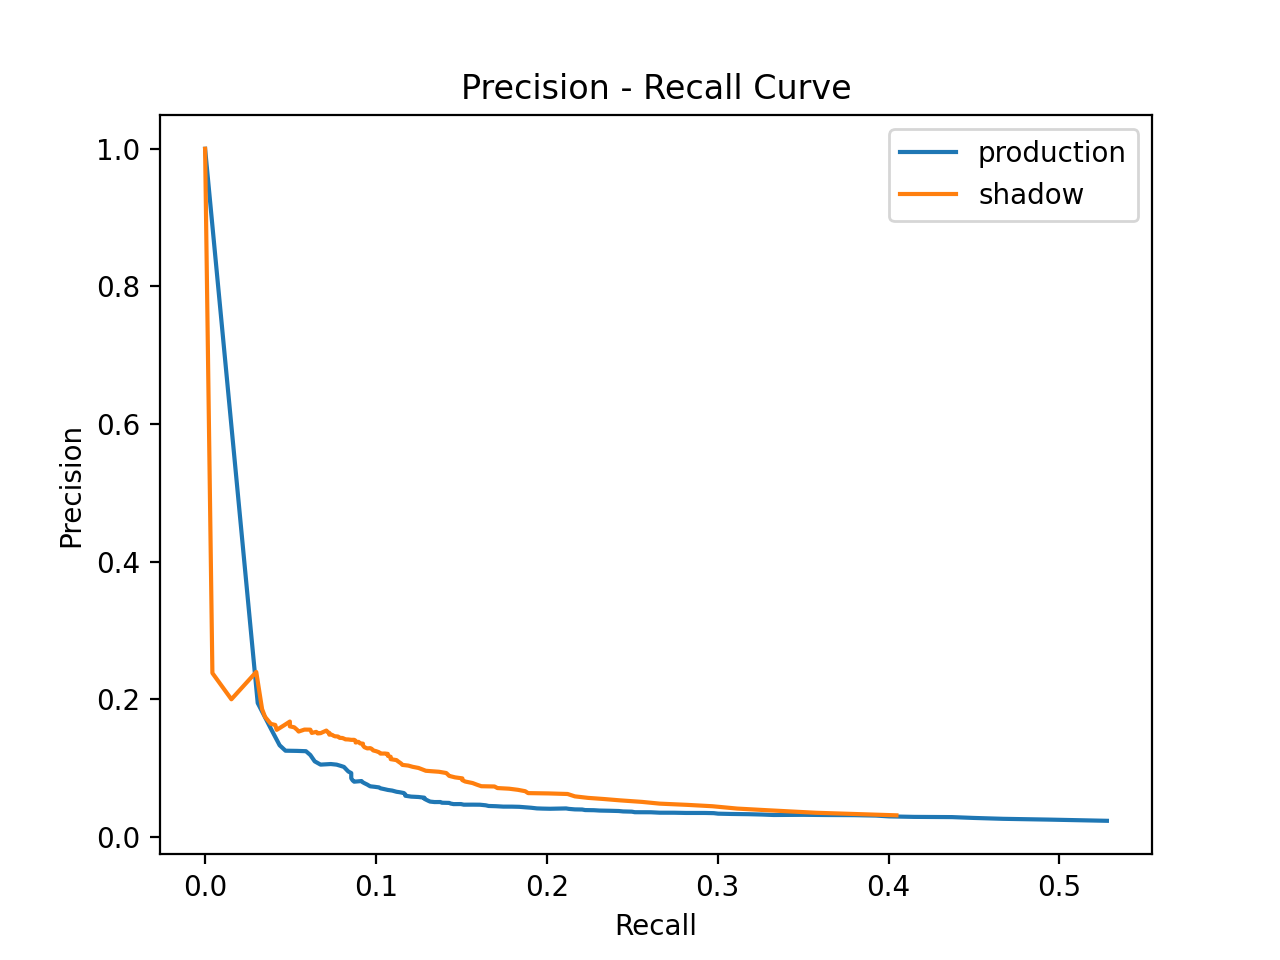

In [40]:
plt.plot(recall_1[1:], prec_1[1:], label="production")
plt.plot(recall_2[1:], prec_2[1:], label="shadow")
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()  # This line will display the labels
plt.show()

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/1522470253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/1522470253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_44077/1522470253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<Figure size 800x500 with 0 Axes>

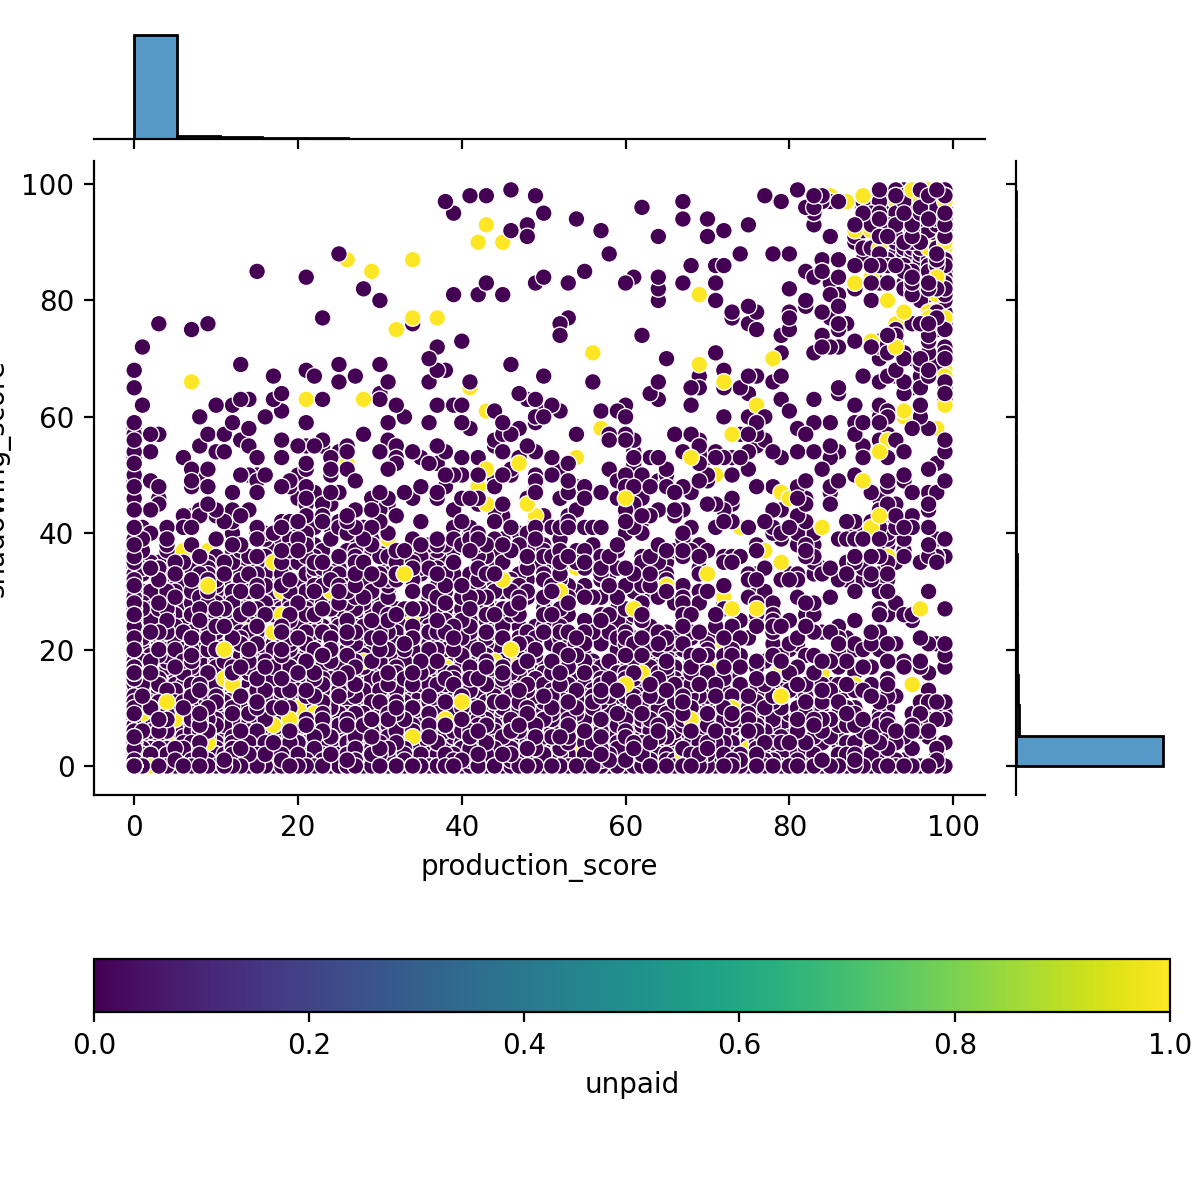

In [41]:
def plot_analytics(simplier_df,x,y,z,figsize=(8, 5)):
    simplier_df[x] = simplier_df[x].fillna(0).astype(float)
    simplier_df[y] = simplier_df[y].fillna(0).astype(float)
    simplier_df[z] = simplier_df[z].fillna(0).astype(float)

    plt.figure(num=1, figsize=figsize)
    g = sns.jointplot(x=simplier_df[x].values, y=simplier_df[y].values, c=simplier_df[z].values, joint_kws={"color":None, 'cmap':'viridis'})
    g.fig.colorbar(g.ax_joint.collections[0], ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal',label=z)
    g.set_axis_labels(xlabel=x, ylabel=y)
    plt.show()
    
plot_analytics(df_out,"production_score","shadowing_score","unpaid",figsize=(8, 5))

In [42]:
cash_unpaid_query = """ 
--WITH CASH_UNPAID AS (
SELECT DISTINCT
    DATE (date_trunc('day'
   , rfs.risk_feature_snapshot_creation_datetime)) AS creation_date
   , CASE WHEN NULLIF (json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'), ' ') IS NOT NULL THEN 'shadowing' ELSE 'production' END AS is_shadowing
        , CASE WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 0 THEN 'NC' ELSE 'EC'
END AS customer_type
        , CASE WHEN p.payment_status = 'NOT_PAID' THEN 1 ELSE 0
END AS unpaid
        , o.order_total_purchase_eur AS gmv_euros
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') AS shadowing_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') AS production_score
        , json_extract_scalar(rfs.features, '$.customer.country') AS order_country
        , rd.decision_id AS decision_id

FROM  sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced rfs -- DANI -PATRICK -- INVESTIGATE HASHING ABOUT THIS -- hash is the control group that we are not actioning anything and we filter them with a shadow rule as we used and understand the outcome
-- hash is a random number, which is to take the 4% random number from the hash
-- safety check is to have not null the shadow score. otherwise would be a random customer which was not in the control group but we got it.
-- Inestigate why the random number of hash with mohammed or someone or Eng.
            INNER JOIN (SELECT customer_id FROM legacy_dwh.public.risk_user_hashing WHERE CAST(hash_crc32 AS real) < (0.04 * CAST(4294967295 AS real)) --This is important
                                                                ) AS cg -- Whys is this? What do this filters out?
                                                                                        ON cg.customer_id = rfs.customer_id
            LEFT JOIN sensitive_delta.central_risk_engine_odp.risk_decisions rd         ON rd.decision_id=rfs.decision_id
            LEFT JOIN sensitive_delta.central_checkout_orders_odp.checkout_orders co    ON co.checkout_id = rfs.checkout_id
            LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 o        ON o.order_id = co.order_id
            LEFT JOIN delta.fintech_payments_odp.payments p                             ON p.order_id = o.order_id
WHERE rfs.checkpoint = 'checkout'
      AND p.payment_method = 'CASH'
      AND p.bundled_payment_parent_id IS NULL -- Why bundled is not possible? -- Debt id from the previous order. new order will have the first id. If null is the first order unpaid or paid. next orsder will have it attached. In this case is not usefull, only for accounting for not double counting debt.
      AND rfs.p_creation_date > current_date  - interval '30' day -- Why 30 days? -- Only to have 1 month of data, speed
      AND o.order_final_status IN ('CanceledStatus', 'DeliveredStatus') -- Is there any other status from this?
      AND NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') IS NOT NULL AND NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') IS NOT NULL
--)
--SELECT DISTINCT * FROM CASH_UNPAID WHERE shadowing_score IS NOT NULL AND production_score IS NOT NULL




    
"""


# Same Comparison at production and shadowing comparison but at NC and EC level

In [43]:
df_test_A=pd.DataFrame(df_out.query("customer_type == 'NC'")['production_score'].value_counts()/len(df_out.query("customer_type == 'NC'")))
df_test_A = df_test_A.reset_index()
df_test_A.columns=['production_score','percentage']
df_test_A

,production_score,percentage
0,0.0,0.275135
1,1.0,0.113696
2,2.0,0.060289
3,3.0,0.049137
4,4.0,0.042516
...,...,...
95,85.0,0.000697
96,94.0,0.000610
97,96.0,0.000610
98,93.0,0.000523


In [44]:
df_test_A=pd.DataFrame(df_out.query("customer_type == 'EC'")['production_score'].value_counts()/len(df_out.query("customer_type == 'NC'")))
df_test_A = df_test_A.reset_index()
df_test_A.columns=['production_score','percentage']
df_test_A

,production_score,percentage
0,0.0,10.535721
1,1.0,0.184527
2,2.0,0.128158
3,3.0,0.097491
4,4.0,0.073619
...,...,...
95,87.0,0.002265
96,79.0,0.002265
97,85.0,0.002178
98,77.0,0.002091


In [45]:
df_test_B=pd.DataFrame(df_out.query("customer_type == 'NC'")['shadowing_score'].value_counts()/len(df_out.query("customer_type == 'NC'")))
df_test_B = df_test_B.reset_index()
df_test_B.columns=['shadowing_score','percentage']
df_test_B

,shadowing_score,percentage
0,0.0,0.684004
1,1.0,0.050009
2,2.0,0.039118
3,4.0,0.027095
4,3.0,0.021868
...,...,...
93,73.0,0.000174
94,82.0,0.000087
95,65.0,0.000087
96,68.0,0.000087


# Model Scores Distributions

In [46]:
production_score_v2=df.groupby(['production_score', 'unpaid']).size().reset_index(name='count')

In [47]:
production_score_v2

,production_score,unpaid,count
0,0,0,123535
1,0,1,552
2,1,0,3383
3,1,1,40
4,10,0,601
...,...,...,...
191,97,1,6
192,98,0,92
193,98,1,9
194,99,0,149
